In [11]:
import numpy as np
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
#-- This block is only required on Google Colab
# import pandas as pd
# import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/glq_mpia'
#--
import contrastive_utils

In [12]:
fl = np.load("./data/processed/ids_images_64.npz")
ids = fl["ids"]
imgs = fl["imgs"]

In [15]:
# Loading model
contrastor = contrastive_utils.Contrastor(
    contrastive_utils.load_augmentor(),
    contrastive_utils.load_encoder(),
    contrastive_utils.load_projector(),
    temperature=0.015,
)
# Compiling model
contrastor.compile(
    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=1e-4), run_eagerly=True
)

In [16]:
# Training model
history = contrastor.fit(
    contrastive_utils.normalise_imgs(imgs),
    batch_size=128,
    epochs=100,
    callbacks=[EarlyStopping(monitor="loss", mode="min", patience=5, verbose=1)],
)
contrastor.save_weights('./models/contrastor', save_format='tf')

Epoch 1/100
52/52 [==============================] - 27s 518ms/step - loss: 5.6199
Epoch 2/100
52/52 [==============================] - 27s 520ms/step - loss: 4.3806
Epoch 3/100
52/52 [==============================] - 27s 523ms/step - loss: 3.2625
Epoch 4/100
52/52 [==============================] - 27s 522ms/step - loss: 2.6278
Epoch 5/100
52/52 [==============================] - 27s 523ms/step - loss: 1.9353
Epoch 6/100
52/52 [==============================] - 28s 540ms/step - loss: 1.9737
Epoch 7/100
52/52 [==============================] - 28s 541ms/step - loss: 1.5373
Epoch 8/100
52/52 [==============================] - 27s 522ms/step - loss: 1.2330
Epoch 9/100
52/52 [==============================] - 27s 524ms/step - loss: 1.0968
Epoch 10/100
52/52 [==============================] - 27s 526ms/step - loss: 1.0198
Epoch 11/100
52/52 [==============================] - 28s 538ms/step - loss: 0.9708
Epoch 12/100
52/52 [==============================] - 28s 530ms/step - loss: 0.9293
E

In [6]:
# Forward passing the original images
encoded_imgs = contrastor.encoder(
    contrastive_utils.normalise_imgs(imgs[:, 2:-2, 2:-2, :])
).numpy()
encoded_imgs = np.array([enc_img / np.linalg.norm(enc_img) for enc_img in encoded_imgs])
np.savez_compressed('./data/processed/encoded_imgs', ids=ids, encoded_imgs=encoded_imgs)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
fl = np.load('./data/processed/encoded_imgs.npz')
ids = fl['ids']
enc_imgs = fl['encoded_imgs']
hzq_df = pd.read_csv('./data/external/known_hzqs.csv')

In [18]:
embedding = PCA(n_components=50).fit_transform(enc_imgs)
embedding = TSNE(n_components=2).fit_transform(embedding)

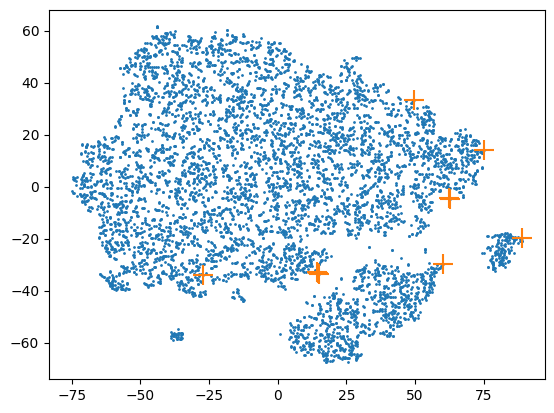

In [19]:
plt.scatter(embedding[:,0], embedding[:,1], s=1)
plt.scatter(
    [embedding[ids.astype(int)==coi, 0] for coi in hzq_df['COADD_OBJECT_ID']],
    [embedding[ids.astype(int)==coi, 1] for coi in hzq_df['COADD_OBJECT_ID']],
    marker='+', s=200
)